In [433]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from sklearn.impute import SimpleImputer
from scipy import stats
from numpy import mean
from numpy import std
import math

import warnings
warnings.filterwarnings("ignore")

In [434]:
input_path = "gs://agriculture-sara/Data sets/Data sets for Modeling/Version 2/All_Manual_Daily_Albedo_NDVI_LST_full.csv"
df = pd.read_csv(input_path, delimiter=',')
df.head()

Date Site Id  Year  Month  Day Climate Vegetation  Latitude  \
0  2000-02-14  FI-Jok  2000      2   14   Other        CRO   60.8986   
1  2000-03-19  FI-Jok  2000      3   19   Other        CRO   60.8986   
2  2000-03-23  FI-Jok  2000      3   23   Other        CRO   60.8986   
3  2000-03-27  FI-Jok  2000      3   27   Other        CRO   60.8986   
4  2000-04-02  FI-Jok  2000      4    2   Other        CRO   60.8986   

   Longitude  Site Id_1  ...  LE_bowen_corr  LE_bowen_corr(mm)  C_BOWENS  \
0   23.51345          1  ...       3.370977           0.116482  0.086856   
1   23.51345          1  ...       5.710514           0.197323  0.186281   
2   23.51345          1  ...      82.078438           2.836159  0.046659   
3   23.51345          1  ...     179.845197           6.214416  0.010955   
4   23.51345          1  ...      50.771181           1.754360  0.227933   

        ETo       EToF       ETr      ETrF  EEflux LST  EEflux NDVI  \
0  0.126001   0.924452  0.214635  0.542695         NaN          NaN   
1  0.159752   1.235184  0.269636  0.731811         NaN        0.000   
2  0.829792   3.417917  1.385714  2.046714         NaN       -0.004   
3  0.461421  13.468007  0.799043  7.777323      271.56       -0.053   
4  1.190954   1.473072  2.006369  0.874396         NaN       -0.018   

   EEflux Albedo  
0            NaN  
1          0.521  
2          0.505  
3          0.507  
4          0.367  

[5 rows x 92 columns]

In [435]:
df = df[df["Site Id"].str.startswith('US-')]

In [436]:
df.isnull().mean() * 100

Date              0.000000
Site Id           0.000000
Year              0.000000
Month             0.000000
Day               0.000000
                   ...    
ETr               9.142076
ETrF              9.142076
EEflux LST       47.704430
EEflux NDVI       9.339069
EEflux Albedo    10.259709
Length: 92, dtype: float64

In [437]:
df.shape

(24874, 92)

In [438]:
print(df[["EEflux LST", "EEflux NDVI", "EEflux Albedo"]].min())
print(df[["EEflux LST", "EEflux NDVI", "EEflux Albedo"]].max())

EEflux LST       257.280
EEflux NDVI       -0.096
EEflux Albedo      0.036
dtype: float64
EEflux LST       329.040
EEflux NDVI        1.000
EEflux Albedo      0.729
dtype: float64


In [439]:
df.dropna(subset=['EEflux NDVI', 'EEflux Albedo'], inplace=True)
df.shape

(21883, 92)

In [440]:
df.isnull().mean() * 100

Date              0.000000
Site Id           0.000000
Year              0.000000
Month             0.000000
Day               0.000000
                   ...    
ETr               7.992506
ETrF              7.992506
EEflux LST       41.333455
EEflux NDVI       0.000000
EEflux Albedo     0.000000
Length: 92, dtype: float64

In [443]:
df[["Date", "Site Id", "EEflux LST", "EEflux NDVI", "EEflux Albedo"]].tail(10)

Date Site Id  EEflux LST  EEflux NDVI  EEflux Albedo
32906  2018-12-22  US-Bi2      274.02        0.165          0.042
32907  2018-12-23  US-Bi2         NaN        0.114          0.041
32908  2018-12-24  US-Bi2         NaN        0.010          0.041
32909  2018-12-25  US-Bi2         NaN        0.290          0.042
32910  2018-12-26  US-Bi2      285.86        0.309          0.042
32911  2018-12-27  US-Bi2         NaN        0.259          0.042
32912  2018-12-28  US-Bi2      283.26        0.281          0.042
32913  2018-12-29  US-Bi2      283.08        0.285          0.042
32914  2018-12-30  US-Bi2      285.84        0.307          0.042
32915  2018-12-31  US-Bi2      282.66        0.282          0.043

In [444]:
def fill_missing(df, target= 'EEflux LST', fill_method='linear', order=2, needsOrder = False, isFill = False):
   # Use interpolation with "spline" and "polynomial" methods. They need order argument
    if needsOrder:
        df[fill_method] = df[target].interpolate(method=fill_method, order=order)
    # Use fillna method  
    elif isFill:
        df[fill_method] = df[target].fillna(method=fill_method)
    else:
        # Use interpolate methods without order argument
        df[fill_method] = df[target].interpolate(method=fill_method)
        
    return df

method: linear
method: time
method: slinear
method: zero
method: ffill
method: bfill
method: rollingmean
method: rollingmedian
method: mean
method: median


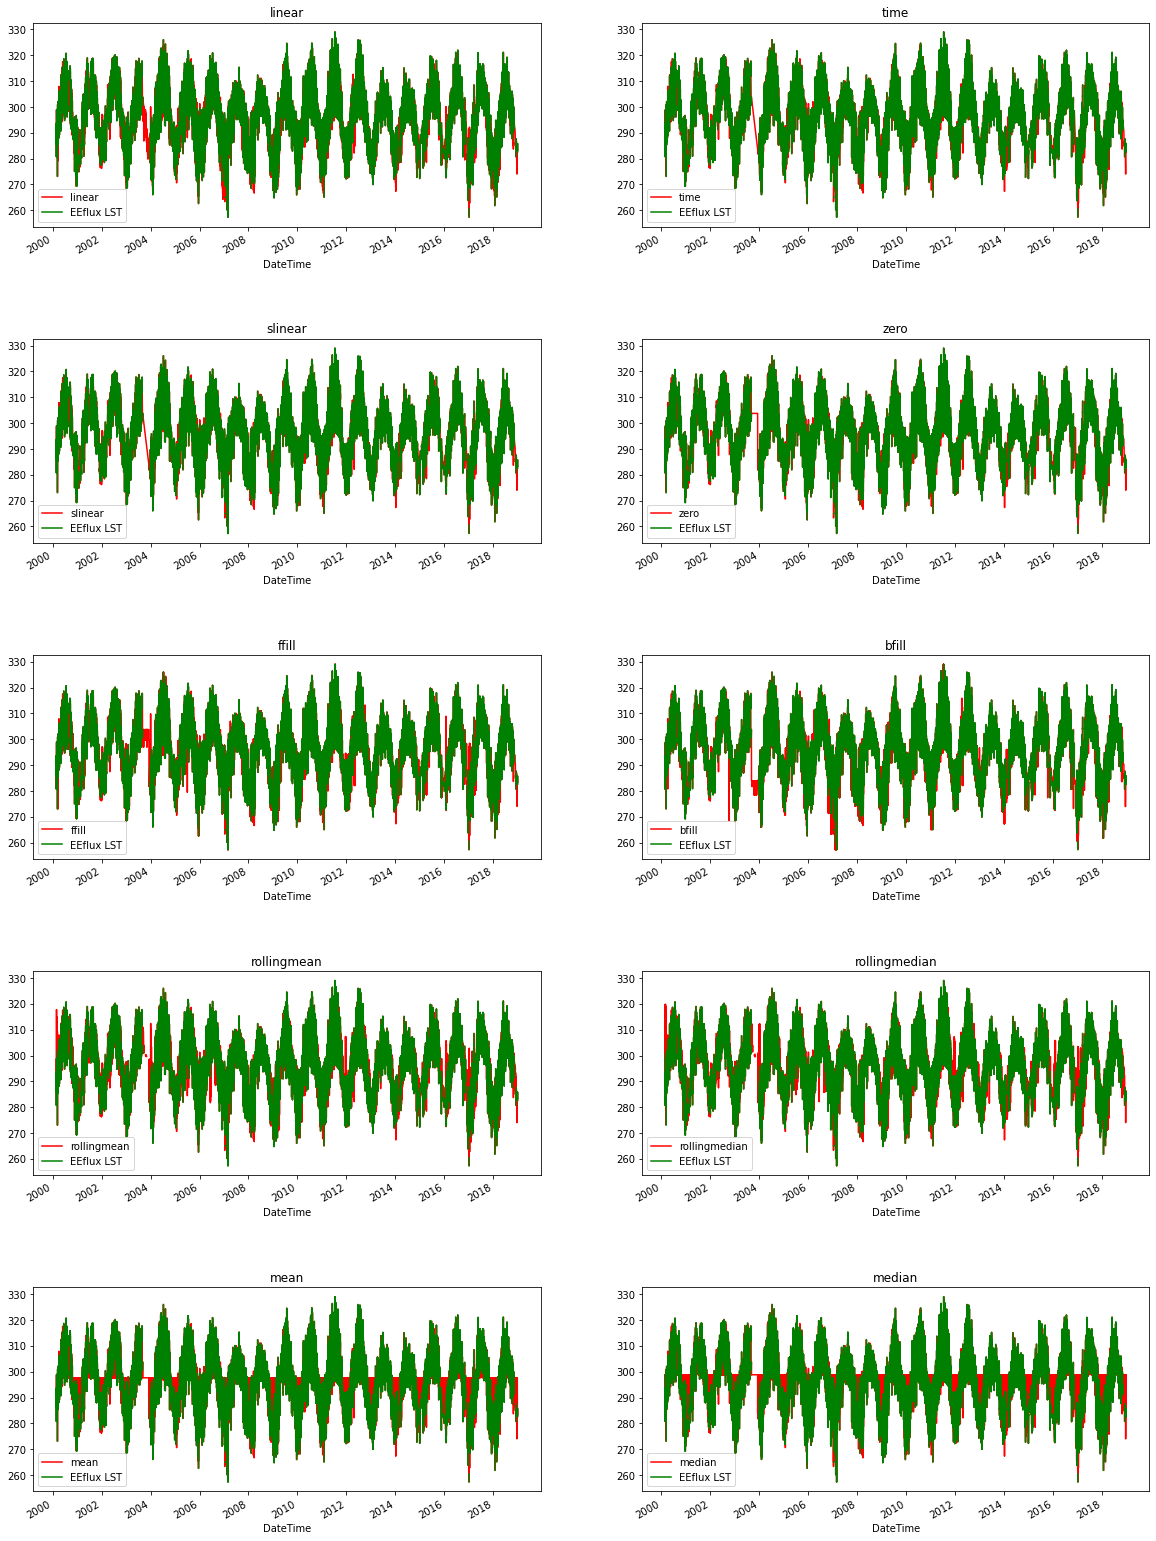

In [445]:
# Create a figure and axes
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 30))
fig.subplots_adjust(hspace=0.55)


df['DateTime'] = df['Date']
df.DateTime = pd.to_datetime(df.DateTime, format='%Y-%m-%d')
df = df.set_index('DateTime')

# List all the methods to be used for filling-in
fill_methods = ['linear', 'time', 'slinear', 'zero',
                'ffill', 'bfill', 'rollingmean', 'rollingmedian',
               'mean', 'median']

needsOrder = False
isFill = False
target = 'EEflux LST'
# Loop over the methods
for method, ax in zip(fill_methods, axes.flatten()):
    print('method:', method)
    if method in ['spline', 'polynomail']:
        needsOrder = True
    if method in ['ffill', 'bfill']:
        isFill = True
    if method in ['rollingmean', 'rollingmedian', 'mean', 'median']:
        if method == 'mean':
            df[method] = df[target].fillna(df[target].mean())
        elif method == 'median':
            df[method] = df[target].fillna(df[target].median())
        elif method == 'rollingmean':
            df[method] = df[target].fillna(df[target].rolling(24, min_periods=1,).mean())
        elif method == 'rollingmedian':
            df[method] = df[target].fillna(df[target].rolling(24, min_periods=1,).median())
    else: 
        df = fill_missing(df, fill_method=method, order=2, needsOrder=needsOrder, isFill = isFill)
    df_plot = df[[method, target]]
    df_plot.plot(ax=ax, color=['red', 'green'])
#     df[target].plot(ax=ax, style='r*')
    ax.set(title=method)

In [446]:
df.columns

Index(['Date', 'Site Id', 'Year', 'Month', 'Day', 'Climate', 'Vegetation',
       'Latitude', 'Longitude', 'Site Id_1',
       ...
       'linear', 'time', 'slinear', 'zero', 'ffill', 'bfill', 'rollingmean',
       'rollingmedian', 'mean', 'median'],
      dtype='object', length=102)

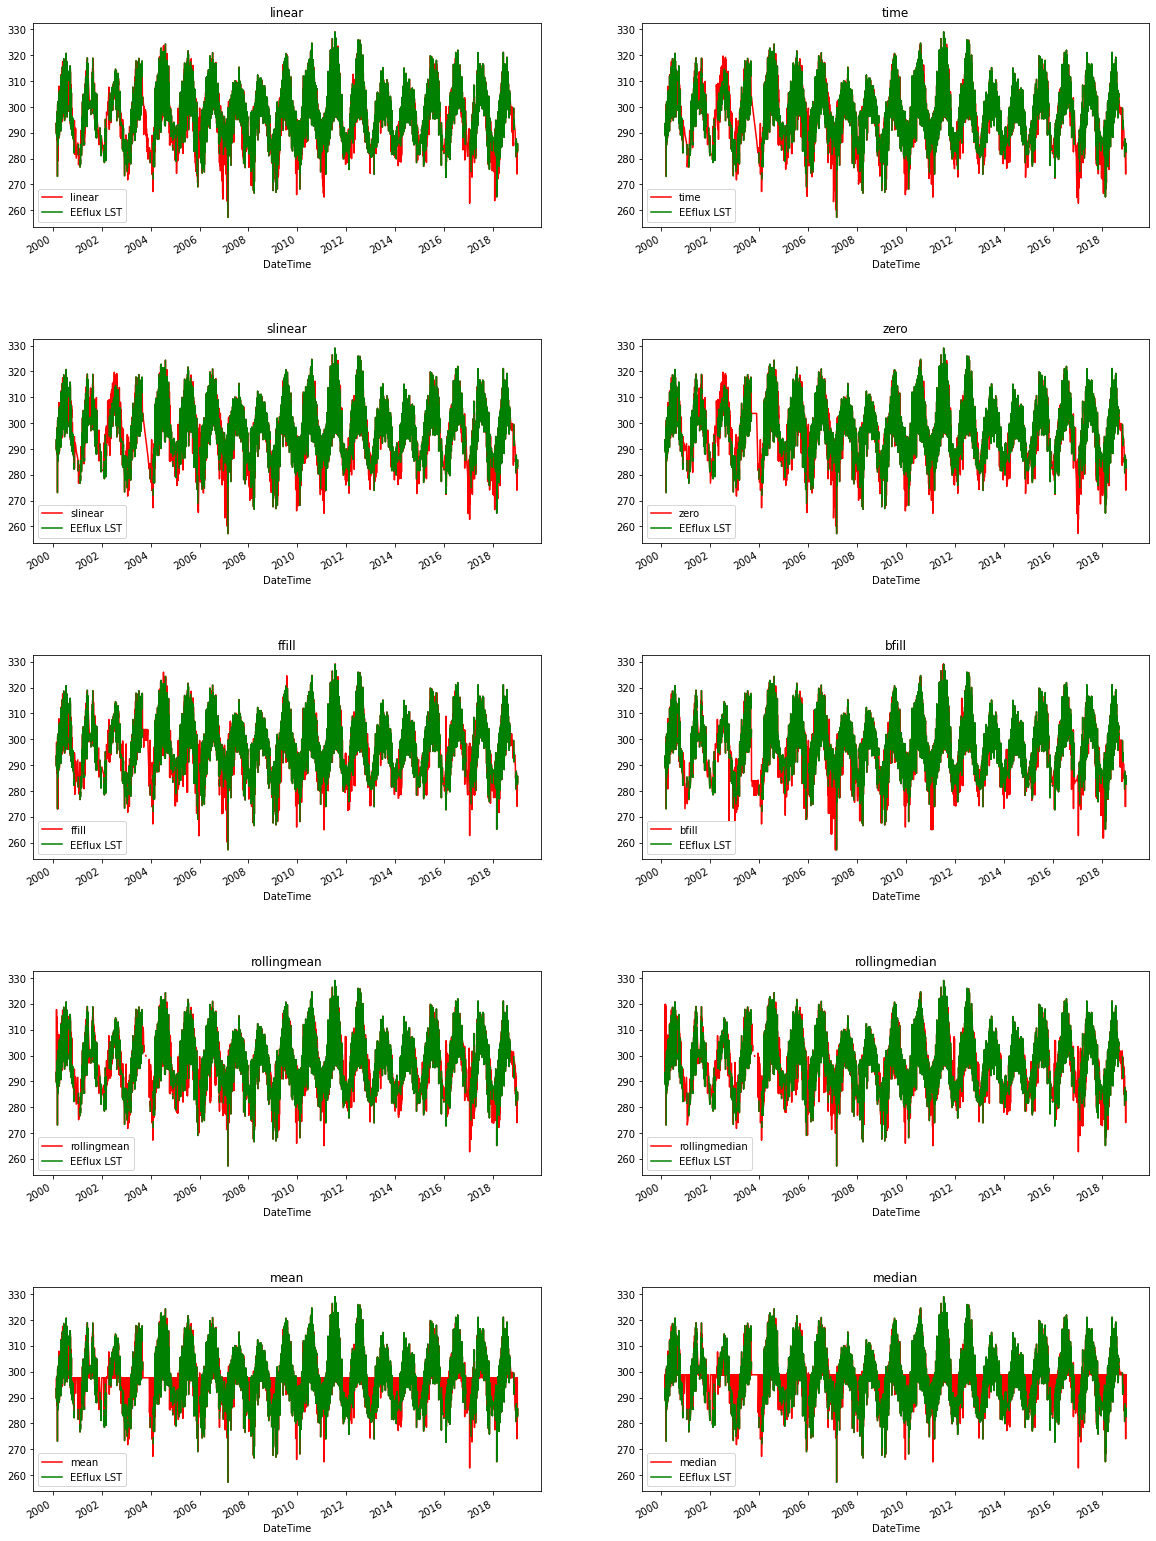

In [447]:
df_filtered = df[df['LE_bowen_corr(mm)'].between(1, 15)]
# Create a figure and axes
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 30))
fig.subplots_adjust(hspace=0.55)

target = 'EEflux LST'
methods = ['linear', 'time', 'slinear', 'zero',
                'ffill', 'bfill', 'rollingmean', 'rollingmedian',
               'mean', 'median']

for method, ax in zip(methods, axes.flatten()):
    df_plot = df_filtered[[method, target]]
    df_plot.plot(ax=ax, color=['red', 'green'])
    ax.set(title=method)

In [448]:
df[["Date", "Site Id", "EEflux Albedo", "EEflux NDVI", "EEflux LST", 
   'linear', 'time', 'slinear', 'zero',
                'ffill', 'bfill', 'rollingmean', 'rollingmedian',
               'mean', 'median']].isnull().mean() * 100

Date              0.000000
Site Id           0.000000
EEflux Albedo     0.000000
EEflux NDVI       0.000000
EEflux LST       41.333455
linear            0.000000
time              0.000000
slinear           0.000000
zero              0.000000
ffill             0.000000
bfill             0.000000
rollingmean       0.342732
rollingmedian     0.342732
mean              0.000000
median            0.000000
dtype: float64

In [451]:
df_test = df
print(df_test.shape)
df_test = df_test.dropna(subset=['rollingmean', 'rollingmedian'])
print(df_test.shape)

(21808, 102)
(21808, 102)


In [452]:
df = df_test
df[["Date", "Site Id", "EEflux Albedo", "EEflux NDVI", "EEflux LST", 
   'linear', 'time', 'slinear', 'zero',
                'ffill', 'bfill', 'rollingmean', 'rollingmedian',
               'mean', 'median']].isnull().mean() * 10

Date             0.000000
Site Id          0.000000
EEflux Albedo    0.000000
EEflux NDVI      0.000000
EEflux LST       4.113169
linear           0.000000
time             0.000000
slinear          0.000000
zero             0.000000
ffill            0.000000
bfill            0.000000
rollingmean      0.000000
rollingmedian    0.000000
mean             0.000000
median           0.000000
dtype: float64

In [455]:
# df[["Date", "Site Id", "EEflux Albedo", "EEflux NDVI", "EEflux LST", 
#    'linear', 'time', 'slinear', 'zero',
#                 'ffill', 'bfill', 'rollingmean', 'rollingmedian',
#                'mean', 'median']].tail(30)

df[["Site Id", "EEflux LST", 
   'linear', 'time', 'rollingmean']].tail(10)

Site Id  EEflux LST  linear    time  rollingmean
DateTime                                                   
2018-12-22  US-Bi2      274.02  274.02  274.02   274.020000
2018-12-23  US-Bi2         NaN  276.98  276.98   284.015000
2018-12-24  US-Bi2         NaN  279.94  279.94   283.877143
2018-12-25  US-Bi2         NaN  282.90  282.90   283.877143
2018-12-26  US-Bi2      285.86  285.86  285.86   285.860000
2018-12-27  US-Bi2         NaN  284.56  284.56   283.811429
2018-12-28  US-Bi2      283.26  283.26  283.26   283.260000
2018-12-29  US-Bi2      283.08  283.08  283.08   283.080000
2018-12-30  US-Bi2      285.84  285.84  285.84   285.840000
2018-12-31  US-Bi2      282.66  282.66  282.66   282.660000

linear is using a step size according to previous and next values
slinear, time, and zero yielded the same results
fffill forwards fill the next value to be the previous NaN value(s)
bfill backwards fill the previous value to be the next NaN value(s)
rolling mean applies a mean according to the window size specified
rolling median applies a median according to the window size specified

In [413]:
df_tmp = df
df_tmp.rename({'time': 'EEflux Time LST', 'linear': 'EEflux Linear LST',
               'rollingmean': 'EEflux RollingMean LST'}, axis=1, inplace=True)
df_tmp.drop(['slinear', 'zero', 'ffill', 'bfill', 'mean', 'median'], axis=1, inplace=True)

def generate_lags_for(df, column, lags_count): 
        for i in range(lags_count):
            lag_name = column + "-" + str(i + 1)
            df[lag_name] = df[column].shift(i + 1)
        return df

def generate_lags(df, lagsForColumns):
    '''This function generates the lags for the list of columns'''
    for k in range(len(lagsForColumns)):
        col = lagsForColumns[k]
        if col in df.columns:
            df = generate_lags_for(df, col, 5)
    return df


lagsForColumns = ["WS", "RH", "TA", "EEflux LST", "EEflux NDVI", "EEflux Albedo",
                 "EEflux Time LST", "EEflux Linear LST", "EEflux RollingMean LST",
                 "NETRAD", "H_bowen_corr", "G"]
df_tmp = generate_lags(df_tmp, lagsForColumns)
df_tmp

Date Site Id  Year  Month  Day Climate Vegetation  Latitude  \
DateTime                                                                        
2000-02-24  2000-02-24  US-WBW  2000      2   24     Cfa        DBF  35.95877   
2000-02-26  2000-02-26  US-WBW  2000      2   26     Cfa        DBF  35.95877   
2000-02-27  2000-02-27  US-WBW  2000      2   27     Cfa        DBF  35.95877   
2000-02-28  2000-02-28  US-WBW  2000      2   28     Cfa        DBF  35.95877   
2000-02-29  2000-02-29  US-WBW  2000      2   29     Cfa        DBF  35.95877   
...                ...     ...   ...    ...  ...     ...        ...       ...   
2018-12-27  2018-12-27  US-Bi2  2018     12   27     Csa        CRO  38.10900   
2018-12-28  2018-12-28  US-Bi2  2018     12   28     Csa        CRO  38.10900   
2018-12-29  2018-12-29  US-Bi2  2018     12   29     Csa        CRO  38.10900   
2018-12-30  2018-12-30  US-Bi2  2018     12   30     Csa        CRO  38.10900   
2018-12-31  2018-12-31  US-Bi2  2018     12   31     Csa        CRO  38.10900   

            Longitude  Site Id_1  ...  EEflux Linear LST-1  \
DateTime                          ...                        
2000-02-24  -84.28743          0  ...                  NaN   
2000-02-26  -84.28743          0  ...               293.46   
2000-02-27  -84.28743          0  ...               298.80   
2000-02-28  -84.28743          0  ...               294.10   
2000-02-29  -84.28743          0  ...               289.40   
...               ...        ...  ...                  ...   
2018-12-27 -121.53500          0  ...               285.86   
2018-12-28 -121.53500          0  ...               284.56   
2018-12-29 -121.53500          0  ...               283.26   
2018-12-30 -121.53500          0  ...               283.08   
2018-12-31 -121.53500          0  ...               285.84   

            EEflux Linear LST-2  EEflux Linear LST-3  EEflux Linear LST-4  \
DateTime                                                                    
2000-02-24                  NaN                  NaN                  NaN   
2000-02-26                  NaN                  NaN                  NaN   
2000-02-27               293.46                  NaN                  NaN   
2000-02-28               298.80               293.46                  NaN   
2000-02-29               294.10               298.80               293.46   
...                         ...                  ...                  ...   
2018-12-27               282.90               279.94               276.98   
2018-12-28               285.86               282.90               279.94   
2018-12-29               284.56               285.86               282.90   
2018-12-30               283.26               284.56               285.86   
2018-12-31               283.08               283.26               284.56   

            EEflux Linear LST-5  EEflux RollingMean LST-1  \
DateTime                                                    
2000-02-24                  NaN                       NaN   
2000-02-26                  NaN                293.460000   
2000-02-27                  NaN                298.800000   
2000-02-28                  NaN                296.130000   
2000-02-29                  NaN                289.400000   
...                         ...                       ...   
2018-12-27               274.02                285.860000   
2018-12-28               276.98                283.811429   
2018-12-29               279.94                283.260000   
2018-12-30               282.90                283.080000   
2018-12-31               285.86                285.840000   

            EEflux RollingMean LST-2  EEflux RollingMean LST-3  \
DateTime                                                         
2000-02-24                       NaN                       NaN   
2000-02-26                       NaN                       NaN   
2000-02-27                293.460000                       NaN   
2000-02-28                298.8

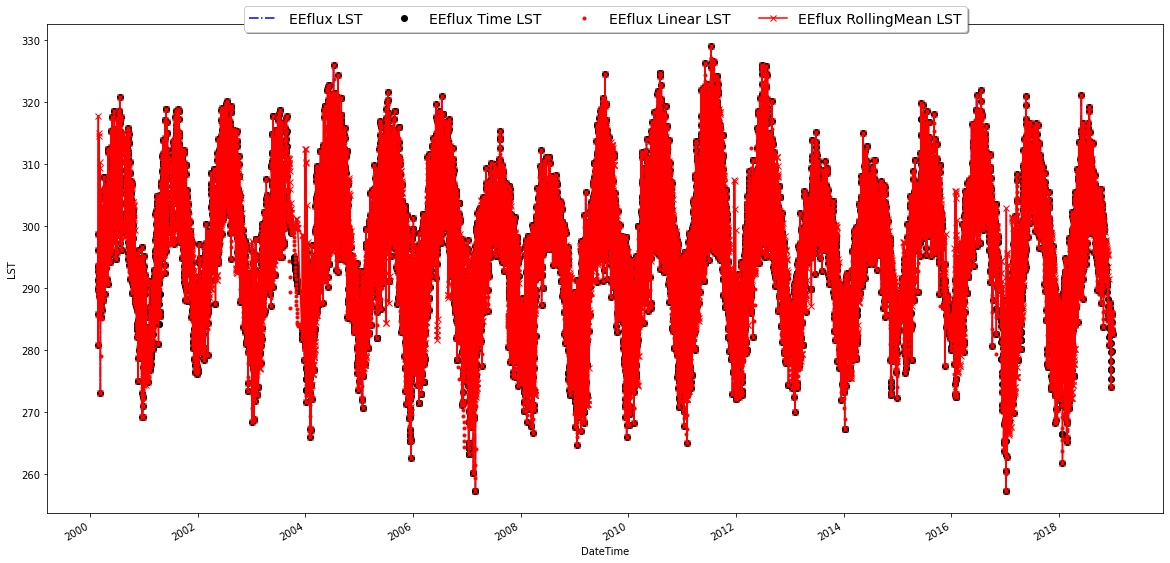

In [393]:
final_df=df_tmp[["EEflux LST", "EEflux Time LST", "EEflux Linear LST", "EEflux RollingMean LST"]]
final_df.plot(style=['b-.', 'ko', 'r.', 'rx-'], figsize=(20,10));
plt.ylabel('LST');
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          fancybox=True, shadow=True, ncol=5, prop={'size': 14} );

In [394]:
df_tmp.columns

Index(['Date', 'Site Id', 'Year', 'Month', 'Day', 'Climate', 'Vegetation',
       'Latitude', 'Longitude', 'Site Id_1',
       ...
       'EEflux Linear LST-1', 'EEflux Linear LST-2', 'EEflux Linear LST-3',
       'EEflux Linear LST-4', 'EEflux Linear LST-5',
       'EEflux RollingMean LST-1', 'EEflux RollingMean LST-2',
       'EEflux RollingMean LST-3', 'EEflux RollingMean LST-4',
       'EEflux RollingMean LST-5'],
      dtype='object', length=126)

In [395]:
df_tmp[["WS", "WS-1", "WS-2", "WS-3", "RH", "RH-1", "RH-2"]]

WS      WS-1      WS-2      WS-3         RH       RH-1  \
DateTime                                                                   
2000-02-24  1.430208       NaN       NaN       NaN  58.329167        NaN   
2000-02-26  1.941915  1.430208       NaN       NaN  60.972340  58.329167   
2000-02-27  1.882069  1.941915  1.430208       NaN  78.810345  60.972340   
2000-02-28  1.287708  1.882069  1.941915  1.430208  60.660417  78.810345   
2000-02-29  1.189375  1.287708  1.882069  1.941915  50.635417  60.660417   
...              ...       ...       ...       ...        ...        ...   
2018-12-27  6.043414  2.504060  6.473731  2.486143  62.998542  61.153125   
2018-12-28  5.318896  6.043414  2.504060  6.473731  54.471042  62.998542   
2018-12-29  1.042243  5.318896  6.043414  2.504060  72.651591  54.471042   
2018-12-30  1.171712  1.042243  5.318896  6.043414  80.772727  72.651591   
2018-12-31  6.972690  1.171712  1.042243  5.318896  60.258947  80.772727   

                 RH-2  
DateTime               
2000-02-24        NaN  
2000-02-26        NaN  
2000-02-27  58.329167  
2000-02-28  60.972340  
2000-02-29  78.810345  
...               ...  
2018-12-27  57.943462  
2018-12-28  61.153125  
2018-12-29  62.998542  
2018-12-30  54.471042  
2018-12-31  72.651591  

[21808 rows x 7 columns]

In [396]:
df_tmp.shape

(21808, 126)

In [397]:
base_path = "gs://agriculture-sara/Data sets/Data sets for Modeling/Version 3/"
export_path = os.path.join(base_path, "Ameriflux_Manual_Imputed" + ".csv")
export_csv = df_tmp.to_csv(export_path, index=None, header=True)